In [1]:
import blitzgsea as blitz
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = [6, 4]

### Load DEGs

In [5]:
genesA = pd.read_csv('~/github/THP1_PrimaryMac_CRISPR/Perturbseq/CRISPRa_gene_list.csv')
genesA = list(genesA['x'])
genesI = pd.read_csv('~/github/THP1_PrimaryMac_CRISPR/Perturbseq/CRISPRi_gene_list.csv')
genesI = list(genesI['x'])

In [7]:
# read in csvs for each gene
CRISPRa_DEGs = {}
CRISPRi_DEGs = {}

for gene in genesA:
   deg = pd.read_csv('~/github/THP1_PrimaryMac_CRISPR/Perturbseq/DEGs_NEW/CRISPRa/'+gene+'.csv')
   CRISPRa_DEGs[gene] = deg

for gene in genesI:
    deg = pd.read_csv('~/github/THP1_PrimaryMac_CRISPR/Perturbseq/DEGs_NEW/CRISPRi/'+gene+'.csv')
    CRISPRi_DEGs[gene] = deg

In [8]:
CRISPRa_DEGs.keys()

dict_keys(['ABCA1', 'ABCA7', 'ABI3', 'ACTB', 'ADA2', 'ADAM10', 'ADGRG1', 'AIF1', 'APOC1', 'APOE', 'APP', 'AXL', 'BIN1', 'C1QA', 'C1QB', 'C1QC', 'C3AR1', 'C9orf72', 'CCR2', 'CD14', 'CD180', 'CD19', 'CD1D', 'CD200R1', 'CD226', 'CD300A', 'CD300C', 'CD300LB', 'CD300LF', 'CD33', 'CD37', 'CD40', 'CD44', 'CD48', 'CD52', 'CD58', 'CD68', 'CD69', 'CD80', 'CD81', 'CD86', 'CDKN2A', 'CEMIP2', 'CHRNE', 'CLDN7', 'CLEC2B', 'CLEC2D', 'CLEC7A', 'CLECL1', 'CLIC1', 'CLN3', 'CLU', 'CR1', 'CR2', 'CSF1R', 'CSF2RA', 'CSF2RB', 'CSF3R', 'CTLA4', 'CTSB', 'CTSH', 'CXCR3', 'CXCR4', 'DPYD', 'EPHA1', 'FCER1G', 'FCGR1A', 'FCGR2A', 'FCGR2B', 'FCGR3A', 'FCGR3B', 'FERMT3', 'FLT1', 'FOLR2', 'FPR1', 'FPR2', 'FPR3', 'GBA', 'GPNMB', 'GPR141', 'GPR183', 'GPR65', 'GPR87', 'GRN', 'HAVCR1', 'HEXA', 'HEXB', 'HLA-DRB5', 'ICAM1', 'ICAM3', 'IFNGR1', 'IFNGR2', 'IL10', 'IL15', 'IL15RA', 'IL1R1', 'IL1R2', 'IL1RN', 'IL21R', 'IL23A', 'IL2RA', 'IL2RG', 'IL6R', 'ILDR1', 'IRF5', 'IRF8', 'ITGA5', 'ITGAL', 'ITGAM', 'ITGAX', 'ITGB2', 'ITGB3',

In [9]:
CRISPRi_DEGs.keys()

dict_keys(['ABCA1', 'ABCA7', 'ABI3', 'ACTB', 'ADA2', 'ADAM10', 'ADGRG1', 'AIF1', 'APOC1', 'APOE', 'APP', 'AXL', 'BIN1', 'C1QA', 'C1QB', 'C1QC', 'C3AR1', 'C9orf72', 'CCR2', 'CD14', 'CD180', 'CD19', 'CD1D', 'CD200R1', 'CD226', 'CD300A', 'CD300C', 'CD300LB', 'CD300LF', 'CD33', 'CD37', 'CD40', 'CD44', 'CD48', 'CD52', 'CD58', 'CD68', 'CD69', 'CD80', 'CD81', 'CD86', 'CEMIP2', 'CHRNE', 'CLDN7', 'CLEC2B', 'CLEC2D', 'CLEC7A', 'CLECL1', 'CLIC1', 'CLN3', 'CLU', 'CR1', 'CR2', 'CSF1R', 'CSF2RA', 'CSF2RB', 'CSF3R', 'CTLA4', 'CTSB', 'CTSH', 'CXCR3', 'CXCR4', 'DPYD', 'EPHA1', 'FCER1G', 'FCGR1A', 'FCGR2A', 'FCGR2B', 'FCGR3A', 'FCGR3B', 'FERMT3', 'FLT1', 'FOLR2', 'FPR1', 'FPR2', 'FPR3', 'GBA', 'GPNMB', 'GPR141', 'GPR183', 'GPR65', 'GPR87', 'GRN', 'HAVCR1', 'HEXA', 'HEXB', 'HLA-DRB5', 'ICAM1', 'ICAM3', 'IFNGR1', 'IFNGR2', 'IL10', 'IL15', 'IL15RA', 'IL1R1', 'IL1R2', 'IL1RN', 'IL21R', 'IL23A', 'IL2RA', 'IL2RG', 'IL6R', 'ILDR1', 'IRF5', 'IRF8', 'ITGA5', 'ITGAL', 'ITGAM', 'ITGAX', 'ITGB2', 'ITGB3', 'ITM2B', 

In [11]:
# calculate "z scores"
for gene in genesA:
    CRISPRa_DEGs[gene]['Zscore'] = np.sign(CRISPRa_DEGs[gene]['lfc']) * -np.log10(CRISPRa_DEGs[gene]['adj_pval'])

for gene in genesI:
    CRISPRi_DEGs[gene]['Zscore'] = np.sign(CRISPRi_DEGs[gene]['lfc']) * -np.log10(CRISPRi_DEGs[gene]['adj_pval'])

### Get number of DEGs per perturbation

In [13]:
CRISPRa_number_of_DEGs = pd.DataFrame({'gene': genesA,
                                       'num_degs': 0})
CRISPRi_number_of_DEGs = pd.DataFrame({'gene': genesI, 
                                       'num_degs': 0})

for gene in genesA:
    num_degs = CRISPRa_DEGs[gene].loc[CRISPRa_DEGs[gene]['adj_pval'] <= 0.05].shape[0]
    CRISPRa_number_of_DEGs.loc[CRISPRa_number_of_DEGs['gene'] == gene, 'num_degs'] = num_degs

for gene in genesI:
    num_degs = CRISPRi_DEGs[gene].loc[CRISPRi_DEGs[gene]['adj_pval'] <= 0.05].shape[0]
    CRISPRi_number_of_DEGs.loc[CRISPRi_number_of_DEGs['gene'] == gene, 'num_degs'] = num_degs

In [14]:
CRISPRa_number_of_DEGs = CRISPRa_number_of_DEGs.loc[CRISPRa_number_of_DEGs['num_degs'] != 0].sort_values('num_degs', ascending = False)

Text(0.5, 1.0, 'Number DEGs for CRISPRa')

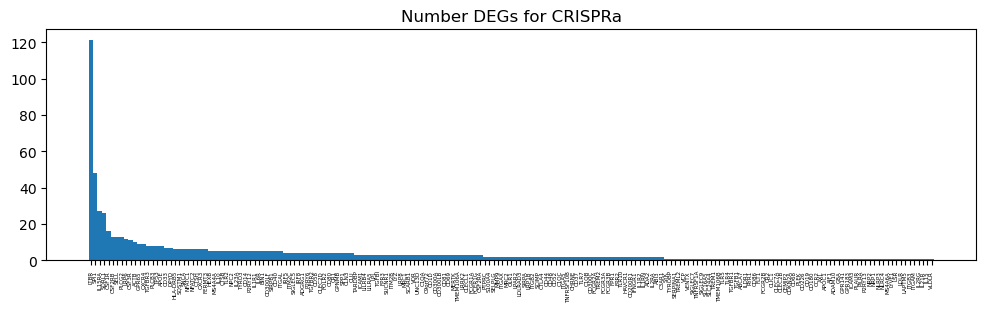

In [15]:
plt.figure(figsize=(12,3))
plt.bar(CRISPRa_number_of_DEGs['gene'], height = CRISPRa_number_of_DEGs['num_degs'], width = 1)
plt.tick_params(axis='x', labelrotation=90)
plt.xticks(fontsize=4)
plt.title('Number DEGs for CRISPRa')

In [16]:
CRISPRi_number_of_DEGs = CRISPRi_number_of_DEGs.loc[CRISPRi_number_of_DEGs['num_degs'] != 0].sort_values('num_degs', ascending = False)

Text(0.5, 1.0, 'Number DEGs for CRISPRi')

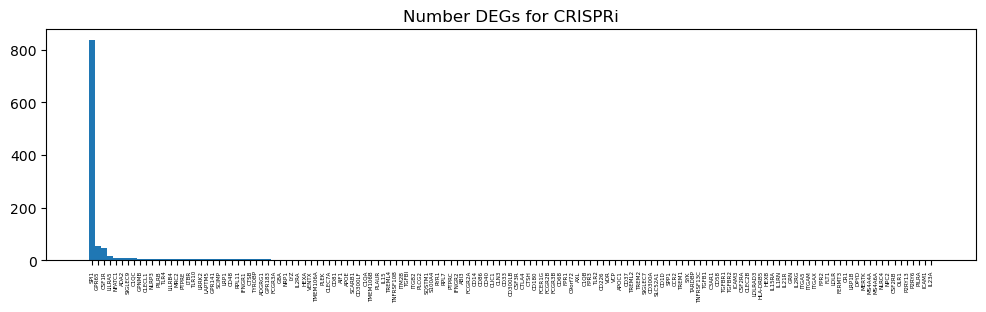

In [17]:
plt.figure(figsize=(12,3))
plt.bar(CRISPRi_number_of_DEGs['gene'], height = CRISPRi_number_of_DEGs['num_degs'], width = 1)
plt.tick_params(axis='x', labelrotation=90)
plt.xticks(fontsize=4)
plt.title('Number DEGs for CRISPRi')

### Create square z score matrix

In [18]:
CRISPRa_matrix = pd.DataFrame({'gene': genesA})

for gene in genesA:
    #print(gene)
    gene_df = CRISPRa_DEGs[gene].loc[CRISPRa_DEGs[gene]['name'].isin(genesA), ('name', 'Zscore')]
    gene_df.rename(columns = {'name': 'gene',
                    'Zscore': gene}, inplace = True)
    CRISPRa_matrix = pd.merge(CRISPRa_matrix, gene_df, how = 'left', on = 'gene')

CRISPRa_matrix.set_index('gene', inplace = True)

In [19]:
nan_genes = list(CRISPRa_matrix[CRISPRa_matrix.isna().any(axis=1)].index)

In [20]:
CRISPRa_matrix_nona = CRISPRa_matrix.dropna()
CRISPRa_matrix_nona.drop(columns = nan_genes, inplace = True)

/tmp/ipykernel_3689570/2957730157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CRISPRa_matrix_nona.drop(columns = nan_genes, inplace = True)


In [21]:
CRISPRa_matrix_nona.shape

(199, 199)

Text(119.44444444444444, 0.5, 'Zscore')

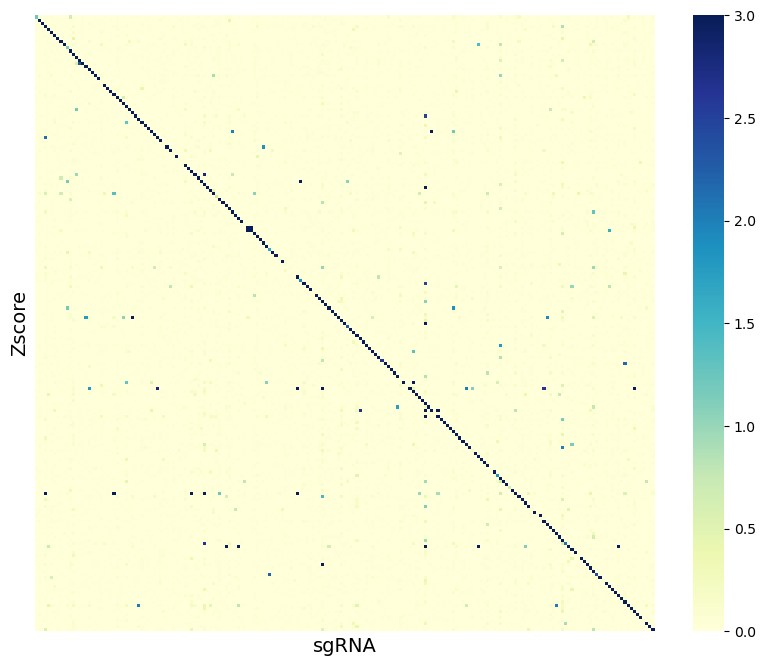

In [19]:
plt.figure(figsize = (10,8))
#sns.set(font_scale=0.5)
ax = sns.heatmap(CRISPRa_matrix_nona, cmap = 'YlGnBu', vmin = 0, vmax = 3, yticklabels = False, xticklabels = False)
plt.xlabel('sgRNA', fontsize=14)
#plt.xticks(fontsize=3)
plt.ylabel('Zscore', fontsize = 14)
#plt.yticks(fontsize=3)
#plt.savefig("CRISPRa_heatmap.png")

In [22]:
CRISPRi_matrix = pd.DataFrame({'gene': genesI})

for gene in genesI:
    gene_df = CRISPRi_DEGs[gene].loc[CRISPRi_DEGs[gene]['name'].isin(genesI), ('name', 'Zscore')]
    gene_df.rename(columns = {'name': 'gene',
                    'Zscore': gene}, inplace = True)
    CRISPRi_matrix = pd.merge(CRISPRi_matrix, gene_df, how = 'left', on = 'gene')

CRISPRi_matrix.set_index('gene', inplace = True)

In [23]:
nan_genes = list(CRISPRi_matrix[CRISPRi_matrix.isna().any(axis=1)].index)

In [24]:
CRISPRi_matrix_nona = CRISPRi_matrix.dropna()
CRISPRi_matrix_nona.drop(columns = nan_genes, inplace = True)

/tmp/ipykernel_3689570/1382207584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CRISPRi_matrix_nona.drop(columns = nan_genes, inplace = True)


In [25]:
CRISPRi_matrix_nona.shape

(189, 189)

Text(119.44444444444444, 0.5, 'Zscore')

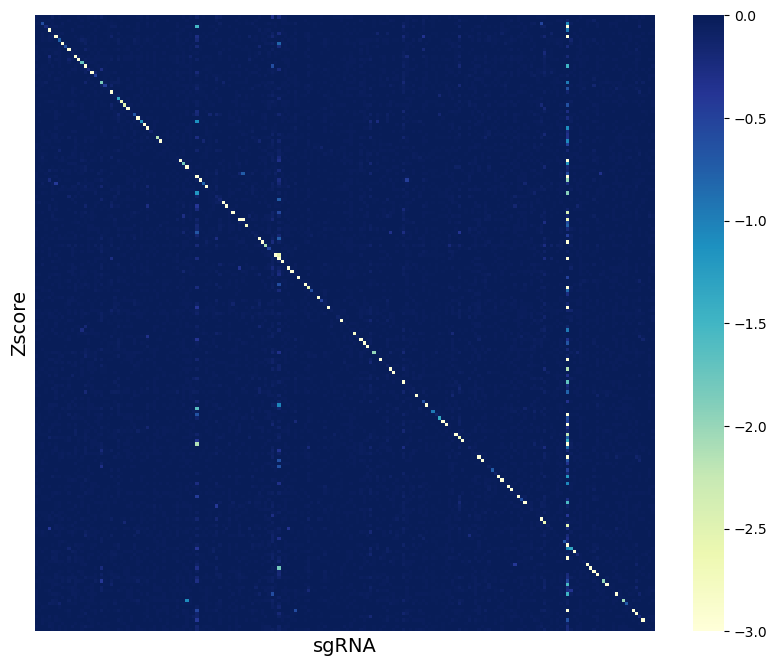

In [24]:
plt.figure(figsize = (10,8))
#sns.set(font_scale=0.5)
ax = sns.heatmap(CRISPRi_matrix_nona, cmap = 'YlGnBu', vmax = 0, vmin = -3, yticklabels = False, xticklabels = False)
plt.xlabel('sgRNA', fontsize=14)
plt.ylabel('Zscore', fontsize = 14)
#plt.savefig("CRISPRi_heatmap.png")

### Order by expression in NT cells

In [26]:
from scipy.io import mmread
from scipy.sparse import csc_matrix
import anndata as ad
import scanpy as sc

In [27]:
CRISPRi_counts = mmread("CRISPRi_seurat5_NEW.mtx")
CRISPRi_var_df = pd.read_csv("CRISPRi_seurat5_NEW_genes.tsv", sep = '\t', index_col = 0, header = None)
CRISPRi_obs_df = pd.read_csv("CRISPRi_seurat5_NEW_metadata.csv", index_col = 0)

ValueError: Line 1: Not a Matrix Market file. Missing banner.

In [27]:
CRISPRi_adata = ad.AnnData(X = csc_matrix(CRISPRi_counts.T),
                           obs = CRISPRi_obs_df,
                           var = CRISPRi_var_df)

In [28]:
NT_cells_CRISPRi = CRISPRi_adata.obs_names[CRISPRi_adata.obs['Gene_Targeted'] == 'NT']

In [29]:
NT_expression_CRISPRi = CRISPRi_adata[NT_cells_CRISPRi, :].X

In [30]:
CRISPRi_NT_df = pd.DataFrame(NT_expression_CRISPRi.toarray(), index=NT_cells_CRISPRi, columns=CRISPRi_adata.var_names)

In [31]:
CRISPRi_NT_df.shape

(2184, 36601)

In [32]:
CRISPRi_NT_df = CRISPRi_NT_df[CRISPRi_matrix_nona.columns]

In [33]:
CRISPRi_NT_avgexp = CRISPRi_NT_df.mean()

In [34]:
CRISPRi_genes_ordered = list(CRISPRi_NT_avgexp.sort_values(ascending = False).index)

In [35]:
CRISPRi_matrix_nona_reordered = CRISPRi_matrix_nona.reindex(CRISPRi_genes_ordered)
CRISPRi_matrix_nona_reordered = CRISPRi_matrix_nona_reordered[CRISPRi_genes_ordered]

In [55]:
CRISPRi_matrix_nona_reordered.to_csv('CRISPRi_Zscore_square_matrix.csv')

Text(119.44444444444444, 0.5, 'DEGs')

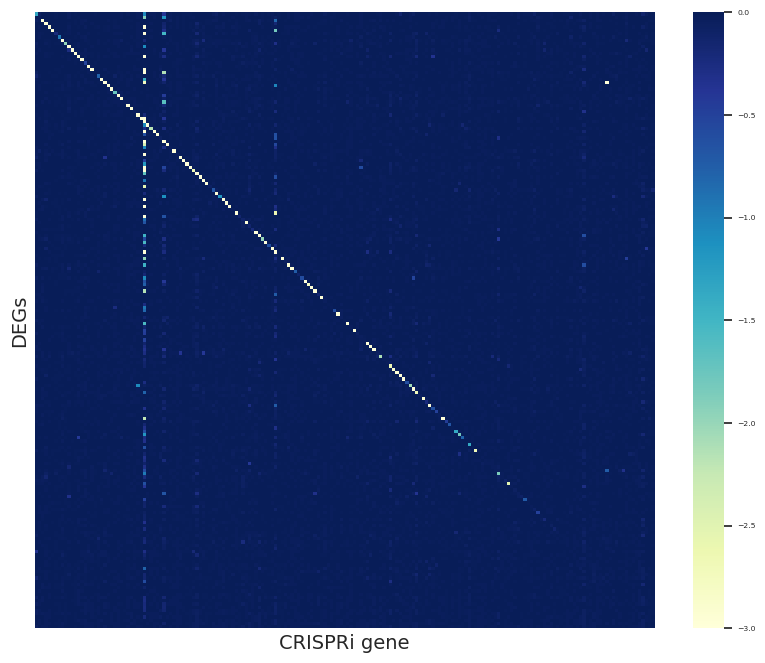

In [36]:
plt.figure(figsize = (10,8))
sns.set(font_scale=0.5)
ax = sns.heatmap(CRISPRi_matrix_nona_reordered, cmap = 'YlGnBu', vmax = 0, vmin = -3, yticklabels = False, xticklabels = False)
plt.xlabel('CRISPRi gene', fontsize=14)
plt.ylabel('DEGs', fontsize = 14)
#plt.savefig("CRISPRi_heatmap_reordered.png")

In [37]:
CRISPRa_counts = mmread("CRISPRa_seurat5_NEW.mtx")
CRISPRa_var_df = pd.read_csv("CRISPRa_seurat5_NEW_genes.tsv", sep = '\t', index_col = 0, header = None)
CRISPRa_obs_df = pd.read_csv("CRISPRa_seurat5_NEW_metadata.csv", index_col = 0)

In [38]:
CRISPRa_adata = ad.AnnData(X = csc_matrix(CRISPRa_counts.T),
                           obs = CRISPRa_obs_df,
                           var = CRISPRa_var_df)

In [39]:
NT_cells_CRISPRa = CRISPRa_adata.obs_names[CRISPRa_adata.obs['Gene_Targeted'] == 'NT']

In [40]:
NT_expression_CRISPRa = CRISPRa_adata[NT_cells_CRISPRa, :].X

In [41]:
CRISPRa_NT_df = pd.DataFrame(NT_expression_CRISPRa.toarray(), index=NT_cells_CRISPRa, columns=CRISPRa_adata.var_names)

In [42]:
CRISPRa_NT_df.shape

(2117, 19162)

In [43]:
CRISPRa_NT_df = CRISPRa_NT_df[CRISPRa_matrix_nona.columns]

In [44]:
CRISPRa_NT_avgexp = CRISPRa_NT_df.mean()

In [45]:
CRISPRa_genes_ordered = list(CRISPRa_NT_avgexp.sort_values(ascending = False).index)

In [46]:
CRISPRa_matrix_nona_reordered = CRISPRa_matrix_nona.reindex(CRISPRa_genes_ordered)
CRISPRa_matrix_nona_reordered = CRISPRa_matrix_nona_reordered[CRISPRa_genes_ordered]

In [54]:
CRISPRa_matrix_nona_reordered.to_csv('CRISPRa_Zscore_square_matrix.csv')

Text(119.44444444444444, 0.5, 'DEGs')

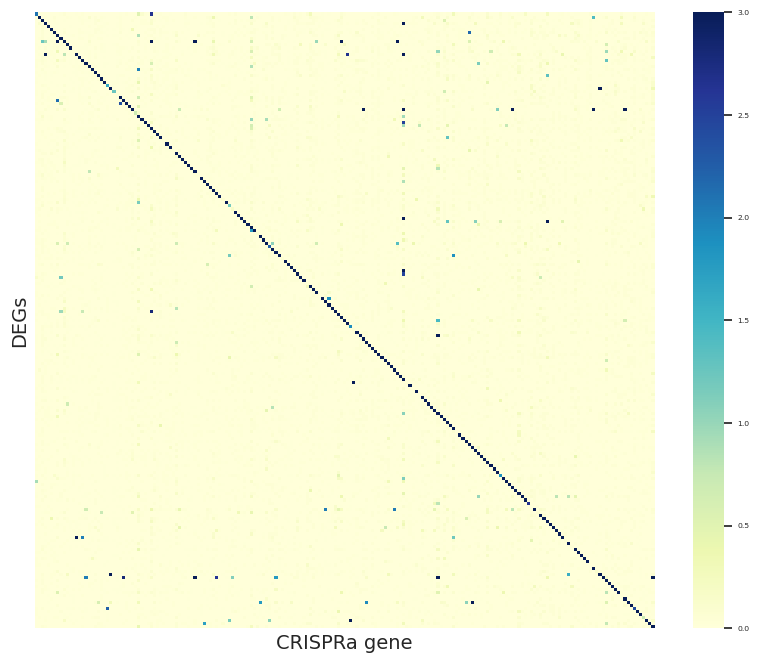

In [47]:
plt.figure(figsize = (10,8))
sns.set(font_scale=0.5)
ax = sns.heatmap(CRISPRa_matrix_nona_reordered, cmap = 'YlGnBu', vmax = 3, vmin = 0, yticklabels = False, xticklabels = False)
plt.xlabel('CRISPRa gene', fontsize=14)
plt.ylabel('DEGs', fontsize = 14)
#plt.savefig("CRISPRa_heatmap_reordered.png")

### Use LFC for QC plots

In [28]:
CRISPRi_matrix_lfc = pd.DataFrame({'gene': genesI})

for gene in genesI:
    gene_df = CRISPRi_DEGs[gene].loc[CRISPRi_DEGs[gene]['name'].isin(genesI), ('name', 'lfc')]
    gene_df.rename(columns = {'name': 'gene',
                    'lfc': gene}, inplace = True)
    CRISPRi_matrix_lfc = pd.merge(CRISPRi_matrix_lfc, gene_df, how = 'left', on = 'gene')

CRISPRi_matrix_lfc.set_index('gene', inplace = True)

In [29]:
CRISPRa_matrix_lfc = pd.DataFrame({'gene': genesA})

for gene in genesA:
    gene_df = CRISPRa_DEGs[gene].loc[CRISPRa_DEGs[gene]['name'].isin(genesA), ('name', 'lfc')]
    gene_df.rename(columns = {'name': 'gene',
                    'lfc': gene}, inplace = True)
    CRISPRa_matrix_lfc = pd.merge(CRISPRa_matrix_lfc, gene_df, how = 'left', on = 'gene')

CRISPRa_matrix_lfc.set_index('gene', inplace = True)

In [30]:
CRISPRi_lfc_decreases = np.array(CRISPRi_matrix_lfc.values.diagonal())
CRISPRi_lfc_decreases = CRISPRi_lfc_decreases[~np.isnan(CRISPRi_lfc_decreases)]

CRISPRa_lfc_decreases = np.array(CRISPRa_matrix_lfc.values.diagonal())
CRISPRa_lfc_decreases = CRISPRa_lfc_decreases[~np.isnan(CRISPRa_lfc_decreases)]

In [31]:
2 ** np.median(CRISPRa_lfc_decreases) - 1

2.8650734474849338

In [32]:
2 ** np.median(CRISPRi_lfc_decreases) - 1

-0.5729615566901038

In [36]:
medians = combined_data.median()
medians

CRISPRi   -1.227562
CRISPRa    1.950496
dtype: float64

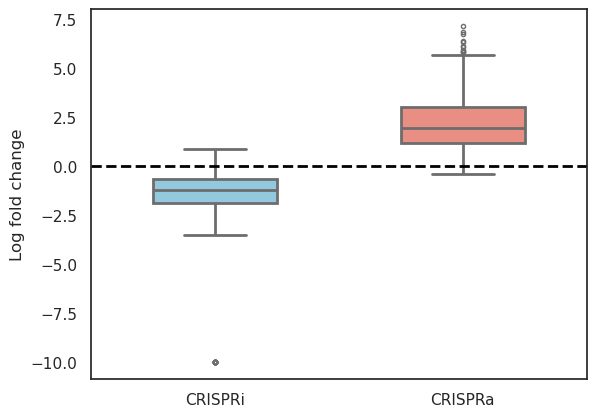

In [33]:
### plt.figure(figsize = (8,5))
skyblue_color = "#87CEEB"  # Hex code for skyblue
salmon_color = "#FA8072"   # Hex code for salmon
my_palette = {"CRISPRi": "skyblue", "CRISPRa": "salmon"}

combined_data = pd.concat([
    pd.Series(CRISPRi_lfc_decreases, name='CRISPRi', index=range(len(CRISPRi_lfc_decreases))),
    pd.Series(CRISPRa_lfc_decreases, name='CRISPRa', index=range(len(CRISPRa_lfc_decreases)))
], keys=['CRISPRi', 'CRISPRa'], axis=1)

# Create a boxplot using Seaborn
sns.set_context('talk')
sns.set_theme(style='white')
sns.boxplot(data=combined_data, palette=my_palette, width = 0.5, linewidth = 2, fliersize = 3)
plt.axhline(0, linestyle = '--', linewidth = 2, color = 'black')
plt.ylabel("Log fold change")
plt.savefig("CRISPRi_CRISPRa_boxplot.png", dpi=300)

### Plot of metaprograms and LFC

#### CRISPRi

In [81]:
metaprogram_genes = pd.read_csv('CRISPR_combined_metaprogram_genes.csv')
metaprogram_genes.drop(columns = 'Unnamed: 0', inplace = True)

In [82]:
for gene in CRISPRi_DEGs.keys():
    df = CRISPRi_DEGs[gene].loc[CRISPRi_DEGs[gene]['name'].isin(metaprogram_genes['Genes'])]
    df = df[['name', 'lfc']]
    df.rename(columns = {'lfc':gene}, inplace = True)
    metaprogram_genes = pd.merge(metaprogram_genes, df, left_on = 'Genes', right_on = 'name', how = 'left')
    metaprogram_genes.drop(columns=['name'], inplace=True)

In [95]:
metaprogram_genes.head()

,MP,Genes,ABCA1,ABCA7,ABI3,ACTB,ADA2,ADAM10,ADGRG1,AIF1,...,TREM2,TREML2,TREML4,TYRO3,TYROBP,UNC13D,VCP,VDR,VENTX,VLDLR
0,MP1,CHI3L1,0.666083,-2.427416,1.514700,0.496781,0.722122,0.450360,-1.009850,0.753274,...,-0.789549,0.852126,-0.907926,-0.633003,0.020217,-0.155856,0.958497,-0.677254,1.132488,0.157029
1,MP1,LPL,-0.659490,1.059869,-0.060000,0.178853,0.518632,0.854744,-1.591040,1.262095,...,-0.766958,0.113602,0.051472,0.044317,0.852021,0.084601,-0.061043,0.087048,0.331626,0.045829
2,MP1,TIMP3,-0.107410,1.305755,-0.078225,1.227895,1.161287,0.549743,-0.261162,1.484394,...,-1.334740,0.643007,0.300479,-0.183995,0.163733,-0.749024,-0.564182,0.723659,0.348892,-0.057863
3,MP1,FN1,0.352761,-0.733101,0.185222,0.005426,-0.001589,0.778461,-0.681370,1.048884,...,-0.811190,-0.252779,-0.498748,-0.147611,0.623584,-0.493077,0.153918,-0.013540,-0.015634,0.309942
4,MP1,CD52,0.137111,-0.260102,0.736281,0.242222,0.341998,0.537635,-0.646305,0.553029,...,0.010390,0.035611,-0.704648,-0.017427,0.959601,0.031428,-0.372348,-0.090986,0.506274,0.064510


In [85]:
z_scores_CRISPRi = pd.read_csv('CRISPRi_module_scores.csv')

In [126]:
z_scores_CRISPRi.sort_values('MP4', ascending = False).tail(10)

,Unnamed: 0,MP1,MP2,MP3,MP4,MP5
45,ITGA5,-0.591796,-0.219650,-1.717943,-1.014250,1.054013
85,VCP,-0.546095,0.556099,-0.930479,-1.042299,0.338251
25,CSF3R,1.735705,-1.119777,-1.008865,-1.122215,0.158136
40,IFNGR1,0.643559,-1.676488,-0.872638,-1.127633,-0.097991
50,LAPTM5,1.440223,-0.793598,-1.044666,-1.158339,0.534975
76,TGFBI,-0.371120,-0.487869,-1.055550,-1.173149,-0.079715
66,RPL11,-1.646980,-0.492343,-0.879672,-1.480997,0.188576
18,CD81,-1.090006,-0.243647,-1.476129,-1.576885,-1.079534
9,CD1D,0.546977,0.161073,-2.057400,-2.179740,2.181856
35,GPR65,0.167929,1.009301,-3.962860,-5.105241,4.838755


In [196]:
z_scores_CRISPRi.set_index('Unnamed: 0', inplace = True)

In [220]:
mp1_zscores = z_scores_CRISPRi.loc[('SIGLEC7', 'CSF1R','PILRA', 'ITGAX', 'TREM2','CD48', 'C1QA', 'AIF1', 'SPI1', 'CSF3R'),]

In [222]:
mp2_zscores = z_scores_CRISPRi.loc[('MS4A4A', 'CD37', 'CD300LB', 'PILRA', 'GPR183','LRP1', 'SPI1', 'PLEK', 'TYROBP', 'ITGAM'),]

In [227]:
mp3_zscores = z_scores_CRISPRi.loc[('SPI1', 'LRP1', 'NLRP3', 'C1QB', 'S100A4','GPR65', 'CD1D', 'ITGA5', 'TREM2', 'CD81'),]

In [229]:
mp4_zscores = z_scores_CRISPRi.loc[('TNFRSF10B', 'C1QB', 'TGFBR2', 'TGFB1', 'NLRP3','GPR65', 'CD1D', 'TGFBI', 'LAPTM5', 'CD81'),]

In [231]:
mp5_zscores = z_scores_CRISPRi.loc[('LRP1', 'FPR3', 'CLIC1', 'C1QC', 'TGFB1','GPR65', 'CD1D', 'TREM2', 'CLECL1', 'IL2RG'),]

In [98]:
mp1_pos = metaprogram_genes[['MP', 'Genes','CD48', 'C1QA', 'AIF1', 'SPI1', 'CSF3R']]
mp1_pos = mp1_pos.loc[mp1_pos['MP'] == 'MP1']

In [116]:
mp1_neg = metaprogram_genes[['MP', 'Genes','SIGLEC7', 'CSF1R', 'PILRA', 'ITGAX', 'TREM2']]
mp1_neg = mp1_neg.loc[mp1_neg['MP'] == 'MP1']

In [120]:
mp2_pos = metaprogram_genes[['MP', 'Genes','MS4A4A', 'CD37', 'CD300LB', 'PILRA', 'GPR183']]
mp2_pos = mp2_pos.loc[mp2_pos['MP'] == 'MP2']

In [121]:
mp2_neg = metaprogram_genes[['MP', 'Genes','LRP1', 'SPI1', 'PLEK', 'TYROBP', 'ITGAM']]
mp2_neg = mp2_neg.loc[mp2_neg['MP'] == 'MP2']

In [123]:
mp3_pos = metaprogram_genes[['MP', 'Genes','SPI1', 'LRP1', 'NLRP3', 'C1QB', 'S100A4']]
mp3_pos = mp3_pos.loc[mp3_pos['MP'] == 'MP3']

In [125]:
mp3_neg = metaprogram_genes[['MP', 'Genes','GPR65', 'CD1D', 'ITGA5', 'TREM2', 'CD81']]
mp3_neg = mp3_neg.loc[mp3_neg['MP'] == 'MP3']

In [132]:
mp4_pos = metaprogram_genes[['MP', 'Genes','TNFRSF10B', 'C1QB', 'TGFBR2', 'TGFB1', 'NLRP3']]
mp4_pos = mp4_pos.loc[mp4_pos['MP'] == 'MP4']

In [130]:
mp4_neg = metaprogram_genes[['MP', 'Genes','GPR65', 'CD1D', 'TGFBI', 'LAPTM5', 'CD81']]
mp4_neg = mp4_neg.loc[mp4_neg['MP'] == 'MP4']

In [181]:
mp5_pos = metaprogram_genes[['MP', 'Genes','GPR65', 'CD1D', 'TREM2', 'CLECL1', 'IL2RG']]
mp5_pos = mp5_pos.loc[mp5_pos['MP'] == 'MP5']

In [183]:
mp5_neg = metaprogram_genes[['MP', 'Genes','LRP1', 'FPR3', 'CLIC1', 'C1QC', 'TGFB1']]
mp5_neg = mp5_neg.loc[mp5_neg['MP'] == 'MP5']

In [138]:
mp1_pos.set_index('Genes', inplace = True)
mp2_pos.set_index('Genes', inplace = True)
mp3_pos.set_index('Genes', inplace = True)
mp4_pos.set_index('Genes', inplace = True)
mp5_pos.set_index('Genes', inplace = True)

In [139]:
mp1_neg.set_index('Genes', inplace = True)
mp2_neg.set_index('Genes', inplace = True)
mp3_neg.set_index('Genes', inplace = True)
mp4_neg.set_index('Genes', inplace = True)
mp5_neg.set_index('Genes', inplace = True)

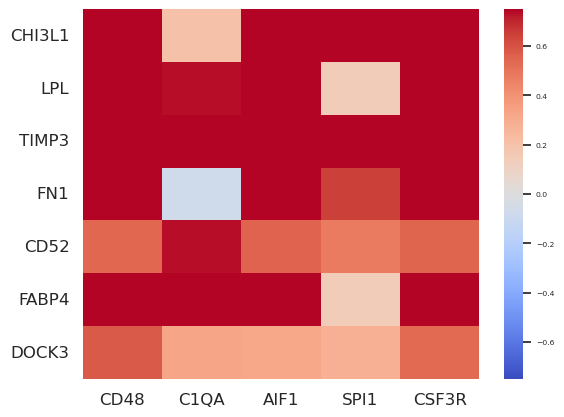

In [193]:
sns.heatmap(mp1_pos.iloc[:, 1:], cmap = 'coolwarm',vmin = -0.75, vmax = 0.75)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12, rotation = 0)
plt.ylabel('')
plt.savefig('MP1_heatmap_CRISPRi_pos.pdf', format='pdf')

Text(55.25, 0.5, '')

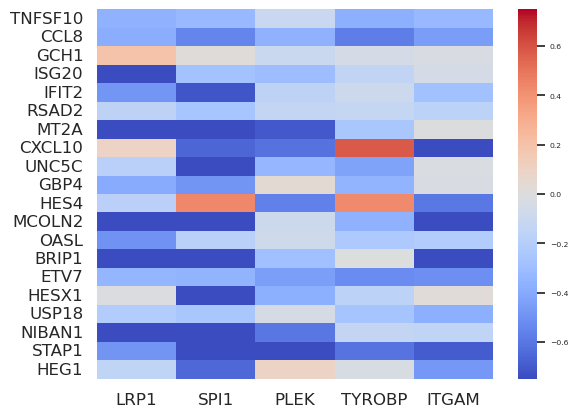

In [256]:
sns.heatmap(mp2_neg.iloc[:, 1:], cmap = 'coolwarm',vmin = -0.75, vmax = 0.75)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12, rotation = 0)
plt.ylabel('')
#plt.savefig('MP1_heatmap_CRISPRi_neg.pdf', format='pdf')

#### CRISPRa

In [406]:
metaprogram_genes = pd.read_csv('CRISPR_combined_metaprogram_genes.csv')
metaprogram_genes.drop(columns = 'Unnamed: 0', inplace = True)

In [407]:
for gene in CRISPRa_DEGs.keys():
    df = CRISPRa_DEGs[gene].loc[CRISPRa_DEGs[gene]['name'].isin(metaprogram_genes['Genes'])]
    df = df[['name', 'lfc']]
    df.rename(columns = {'lfc':gene}, inplace = True)
    metaprogram_genes = pd.merge(metaprogram_genes, df, left_on = 'Genes', right_on = 'name', how = 'left')
    metaprogram_genes.drop(columns=['name'], inplace=True)

In [408]:
metaprogram_genes.head()

,MP,Genes,ABCA1,ABCA7,ABI3,ACTB,ADA2,ADAM10,ADGRG1,AIF1,...,TREM2,TREML2,TREML4,TYRO3,TYROBP,UNC13D,VCP,VDR,VENTX,VLDLR
0,MP1,CHI3L1,-1.804349,-0.433307,0.321756,-0.193437,-0.408694,-1.647276,0.107392,0.581844,...,-2.479619,-0.288631,0.131287,-0.191559,-1.112663,0.044614,-1.059596,-0.062794,-0.126156,0.264818
1,MP1,LPL,-0.490707,0.252137,0.214374,-0.191621,-0.361435,-0.008118,0.623131,0.195152,...,0.238119,0.133609,0.140828,-0.745310,-0.585690,-0.892689,-0.139405,0.282051,0.337684,0.130139
2,MP1,TIMP3,-0.943910,-0.457465,-0.421563,-0.776905,-0.581928,0.537209,0.893134,-0.202450,...,-0.397850,-0.622091,0.158988,-0.420545,0.383886,-0.146034,-0.178634,0.536513,0.052479,-0.155619
3,MP1,FN1,-1.770702,0.109103,-0.493776,-1.118712,0.001465,-0.271162,-0.102692,-0.019076,...,-0.361906,-0.289553,0.220071,-0.161524,-0.582924,0.662346,-0.864062,0.740742,0.171710,0.316029
4,MP1,CD52,-1.061397,-0.627127,-0.038560,0.161308,-0.554217,-0.840554,0.653356,-0.007617,...,-1.114668,0.114814,0.103993,-0.018500,-0.702829,-0.147406,-0.282615,0.058087,0.556633,-0.659156


In [409]:
z_scores_CRISPRa = pd.read_csv('CRISPRa_module_scores.csv')

In [512]:
z_scores_CRISPRa.sort_values('MP1', ascending = False).head(6)

,MP1,MP2,MP3,MP4,MP5
Unnamed: 0,,,,,
CD52,5.010383,-0.772899,-0.295059,-0.235827,-0.922442
PLCB3,3.427947,-2.208520,0.153795,-2.285983,-0.039219
LRP6,2.775118,0.263964,-0.676930,-1.388846,0.467656
CD33,2.486286,-0.550410,-1.235166,-1.778785,1.131776
NFATC1,2.378192,0.872904,0.449680,-0.200091,-1.037722
CSF2RB,2.250390,-2.386535,-0.139536,-0.730576,2.623794


In [411]:
z_scores_CRISPRa.set_index('Unnamed: 0', inplace = True)

In [513]:
mp1_zscores = z_scores_CRISPRa.loc[('ITGAL', 'SELPLG','CD86', 'SQSTM1', 'S100A4','CD52', 'PLCB3', 'LRP6', 'CD33', 'NFATC1'),]

In [425]:
mp2_zscores = z_scores_CRISPRa.loc[('ITGAL', 'TGFB1', 'IL23A', 'MRC1', 'ADGRG1','CD14', 'CSF2RB', 'ABI3', 'PLCB3', 'CSF1R'),]

In [428]:
mp3_zscores = z_scores_CRISPRa.loc[('NFATC2', 'ICAM3', 'SPI1', 'LTBR', 'CLIC1','CXCR4', 'LILRA5', 'CD1D', 'LSR', 'LRP8'),]

In [416]:
mp4_zscores = z_scores_CRISPRa.loc[('LDLR', 'LSR','LDLRAD3', 'TGFB1', 'CLEC2B','SPI1', 'BIN1', 'PLCB3', 'CLIC1', 'MRC2'),]

In [470]:
mp5_zscores = z_scores_CRISPRa.loc[('SPI1', 'CSF2RB', 'CLN3', 'LTBR', 'FPR3','TLR10', 'LRP8', 'NFATC2', 'P2RY13', 'AXL'),]

In [514]:
mp1_pos = metaprogram_genes[['MP', 'Genes','CD52', 'PLCB3', 'LRP6', 'CD33', 'NFATC1']]
mp1_pos = mp1_pos.loc[mp1_pos['MP'] == 'MP1']

In [435]:
mp1_neg = metaprogram_genes[['MP', 'Genes','ITGAL', 'SELPLG','CD86', 'SQSTM1', 'S100A4']]
mp1_neg = mp1_neg.loc[mp1_neg['MP'] == 'MP1']

In [437]:
mp2_pos = metaprogram_genes[['MP', 'Genes','ITGAL', 'TGFB1', 'IL23A', 'MRC1', 'ADGRG1']]
mp2_pos = mp2_pos.loc[mp2_pos['MP'] == 'MP2']

In [438]:
mp2_neg = metaprogram_genes[['MP', 'Genes','CD14', 'CSF2RB', 'ABI3', 'PLCB3', 'CSF1R']]
mp2_neg = mp2_neg.loc[mp2_neg['MP'] == 'MP2']

In [440]:
mp3_pos = metaprogram_genes[['MP', 'Genes','CXCR4', 'LILRA5', 'CD1D', 'LSR', 'LRP8']]
mp3_pos = mp3_pos.loc[mp3_pos['MP'] == 'MP3']

In [441]:
mp3_neg = metaprogram_genes[['MP', 'Genes','NFATC2', 'ICAM3', 'SPI1', 'LTBR', 'CLIC1']]
mp3_neg = mp3_neg.loc[mp3_neg['MP'] == 'MP3']

In [443]:
mp4_pos = metaprogram_genes[['MP', 'Genes','LDLR', 'LSR','LDLRAD3', 'TGFB1', 'CLEC2B']]
mp4_pos = mp4_pos.loc[mp4_pos['MP'] == 'MP4']

In [444]:
mp4_neg = metaprogram_genes[['MP', 'Genes','SPI1', 'BIN1', 'PLCB3', 'CLIC1', 'MRC2']]
mp4_neg = mp4_neg.loc[mp4_neg['MP'] == 'MP4']

In [446]:
mp5_pos = metaprogram_genes[['MP', 'Genes','SPI1', 'CSF2RB', 'CLN3', 'LTBR', 'FPR3']]
mp5_pos = mp5_pos.loc[mp5_pos['MP'] == 'MP5']

In [505]:
mp5_neg = metaprogram_genes[['MP', 'Genes','TLR10', 'LRP8', 'NFATC2', 'P2RY13', 'AXL']]
mp5_neg = mp5_neg.loc[mp5_neg['MP'] == 'MP5']

In [448]:
mp1_pos.set_index('Genes', inplace = True)
mp2_pos.set_index('Genes', inplace = True)
mp3_pos.set_index('Genes', inplace = True)
mp4_pos.set_index('Genes', inplace = True)
mp5_pos.set_index('Genes', inplace = True)

In [449]:
mp1_neg.set_index('Genes', inplace = True)
mp2_neg.set_index('Genes', inplace = True)
mp3_neg.set_index('Genes', inplace = True)
mp4_neg.set_index('Genes', inplace = True)
mp5_neg.set_index('Genes', inplace = True)

Text(46.25, 0.5, '')

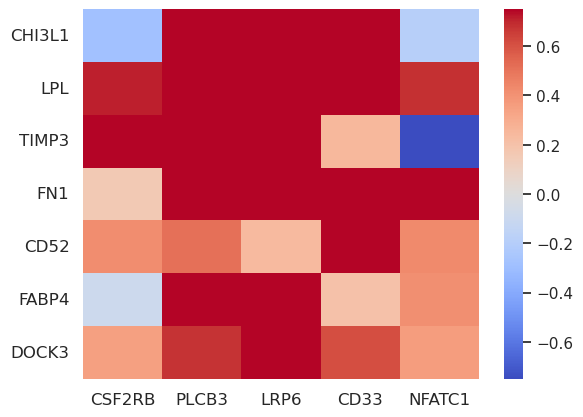

In [516]:
sns.heatmap(mp1_pos.iloc[:, 1:], cmap = 'coolwarm',vmin = -0.75, vmax = 0.75)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12, rotation = 0)
plt.ylabel('')
#plt.savefig('MP5_heatmap_CRISPRa_pos.pdf', format='pdf')

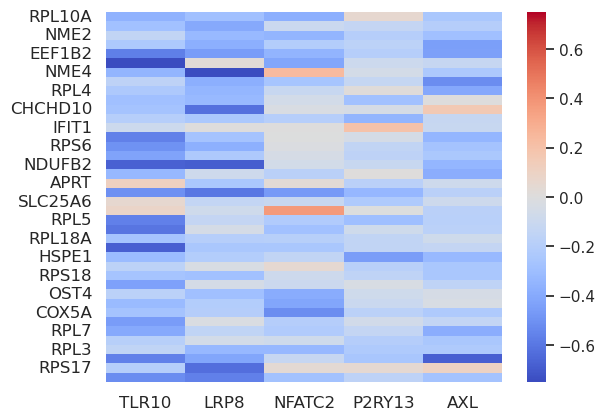

In [507]:
sns.heatmap(mp5_neg.iloc[:, 1:], cmap = 'coolwarm',vmin = -0.75, vmax = 0.75)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12, rotation = 0)
plt.ylabel('')
plt.savefig('MP5_heatmap_CRISPRa_neg.pdf', format='pdf')

### pathway analysis for each MP

In [269]:
metaprogram_gene_lists = {'MP1': metaprogram_genes.loc[metaprogram_genes['MP'] == 'MP1','Genes'].values,
                          'MP2': metaprogram_genes.loc[metaprogram_genes['MP'] == 'MP2','Genes'].values,
                          'MP3': metaprogram_genes.loc[metaprogram_genes['MP'] == 'MP3','Genes'].values,
                          'MP4': metaprogram_genes.loc[metaprogram_genes['MP'] == 'MP4','Genes'].values,
                          'MP5': metaprogram_genes.loc[metaprogram_genes['MP'] == 'MP5','Genes'].values}

In [358]:
enrichr_results = pd.read_csv('metaprogram_enrichments.csv')

In [359]:
enrichr_results['log(pval)'] = -np.log10(enrichr_results['Adjusted P-value'])

In [360]:
enrichr_results.head()

,Metaprogram,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,log(pval)
0,MP1,Interleukin-4 regulation of apoptosis,4/267,0.000001,0.000067,0.0,0.0,100.025349,1376.717890,FN1;CHI3L1;LPL;TIMP3,4.171315
1,MP1,TGF-beta regulation of extracellular matrix,4/565,0.000021,0.000660,0.0,0.0,46.184195,498.315209,FN1;CHI3L1;LPL;TIMP3,3.180772
2,MP1,"Lipid digestion, mobilization, and transport",Feb-48,0.000118,0.001991,0.0,0.0,173.452174,1569.527842,FABP4;LPL,2.700935
3,MP1,Oncostatin M,3/311,0.000124,0.001991,0.0,0.0,47.934253,431.011452,FN1;CHI3L1;LPL,2.700935
4,MP1,PPAR signaling pathway,Feb-69,0.000244,0.002598,0.0,0.0,118.961194,989.756737,FABP4;LPL,2.585300


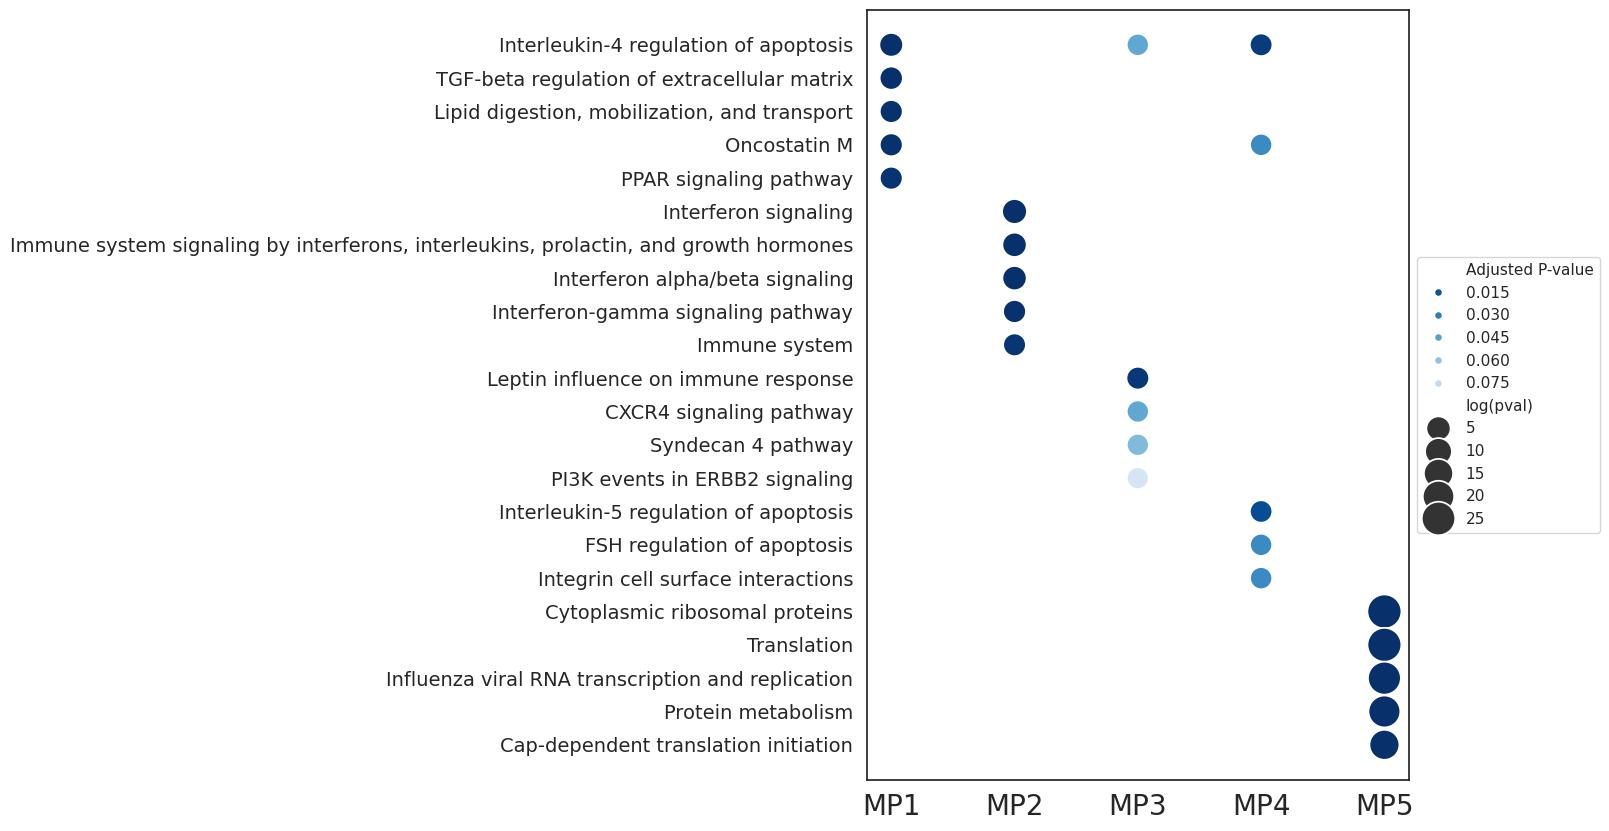

In [401]:
sns.set_theme(style='white')
plt.figure(figsize=(7, 10))
sns.scatterplot(data=enrichr_results,
                x='Metaprogram', y='Term',  # Cluster on x-axis, pathways on y-axis
                size='log(pval)', hue='Adjusted P-value',
                #palette='light:b_r', sizes=(100, 300), hue_norm=(0,0.1)) 
                palette='Blues_r', sizes=(250, 600), hue_norm=(0.001,0.1)) 

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 14)
plt.xlabel('')
plt.ylabel('')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('MP_enrichment_dotplot.pdf', format='pdf')